In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
%matplotlib inline

In [3]:
from sklearn.model_selection import train_test_split
df_all = pd.read_csv("result_trump_tweets.csv", delimiter=',')
df_all.drop(["Unnamed: 0"], axis=1, inplace=True)
df_all = df_all.astype(int)

df_y = df_all['usdx']
df_X = df_all.drop(columns=['usdx'])
X_train_orig, X_test, y_train_orig, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=42)


In [37]:
X_train, X_test_valid, y_train, y_test_valid = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=42)
df_labels = y_train
df_features = X_train
df_features_test = X_test_valid
df_labels_test = y_test_valid

## Radial Basis Function Kernel

In [4]:
#Let's create a validation set
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train_orig, y_train_orig, test_size = 0.25)

In [11]:
C_values = [0.0001, 0.01, 1, 100]
gamma_values = [0.0625, 0.25, 1]

accuracies = {}

for C in C_values:
    for gamma in gamma_values:
        # Create a SVC classifier using an RBF kernel
        svc = SVC(kernel='rbf', random_state=0, gamma=gamma, C=C)
        svc.fit(X_train_val, y_train_val)
        y_pred_val = svc.predict(X_test_val)
        accuracy = accuracy_score(y_test_val,y_pred_val)
        accuracies[f"{C}_{gamma}"] = accuracy
        print(f"C: {C}\t Gamma: {gamma}\t Accuracy: {accuracy}")

C: 0.0001	 Gamma: 0.0625	 Accuracy: 0.48429510591672753
C: 0.0001	 Gamma: 0.25	 Accuracy: 0.48429510591672753
C: 0.0001	 Gamma: 1	 Accuracy: 0.48429510591672753
C: 0.01	 Gamma: 0.0625	 Accuracy: 0.48429510591672753
C: 0.01	 Gamma: 0.25	 Accuracy: 0.48429510591672753
C: 0.01	 Gamma: 1	 Accuracy: 0.48429510591672753
C: 1	 Gamma: 0.0625	 Accuracy: 0.4981738495252009
C: 1	 Gamma: 0.25	 Accuracy: 0.4952520087655223
C: 1	 Gamma: 1	 Accuracy: 0.4864864864864865
C: 100	 Gamma: 0.0625	 Accuracy: 0.44558071585098613
C: 100	 Gamma: 0.25	 Accuracy: 0.49086924762600437
C: 100	 Gamma: 1	 Accuracy: 0.48721694667640614


In [12]:
data = [[key.split("_")[0], key.split("_")[1], accuracies[key]] for key in accuracies.keys()] 
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['C', 'gamma', 'accuracy']) 

In [13]:
df

,C,gamma,accuracy
0,0.0001,0.0625,0.484295
1,0.0001,0.25,0.484295
2,0.0001,1,0.484295
3,0.01,0.0625,0.484295
4,0.01,0.25,0.484295
5,0.01,1,0.484295
6,1,0.0625,0.498174
7,1,0.25,0.495252
8,1,1,0.486486
9,100,0.0625,0.445581


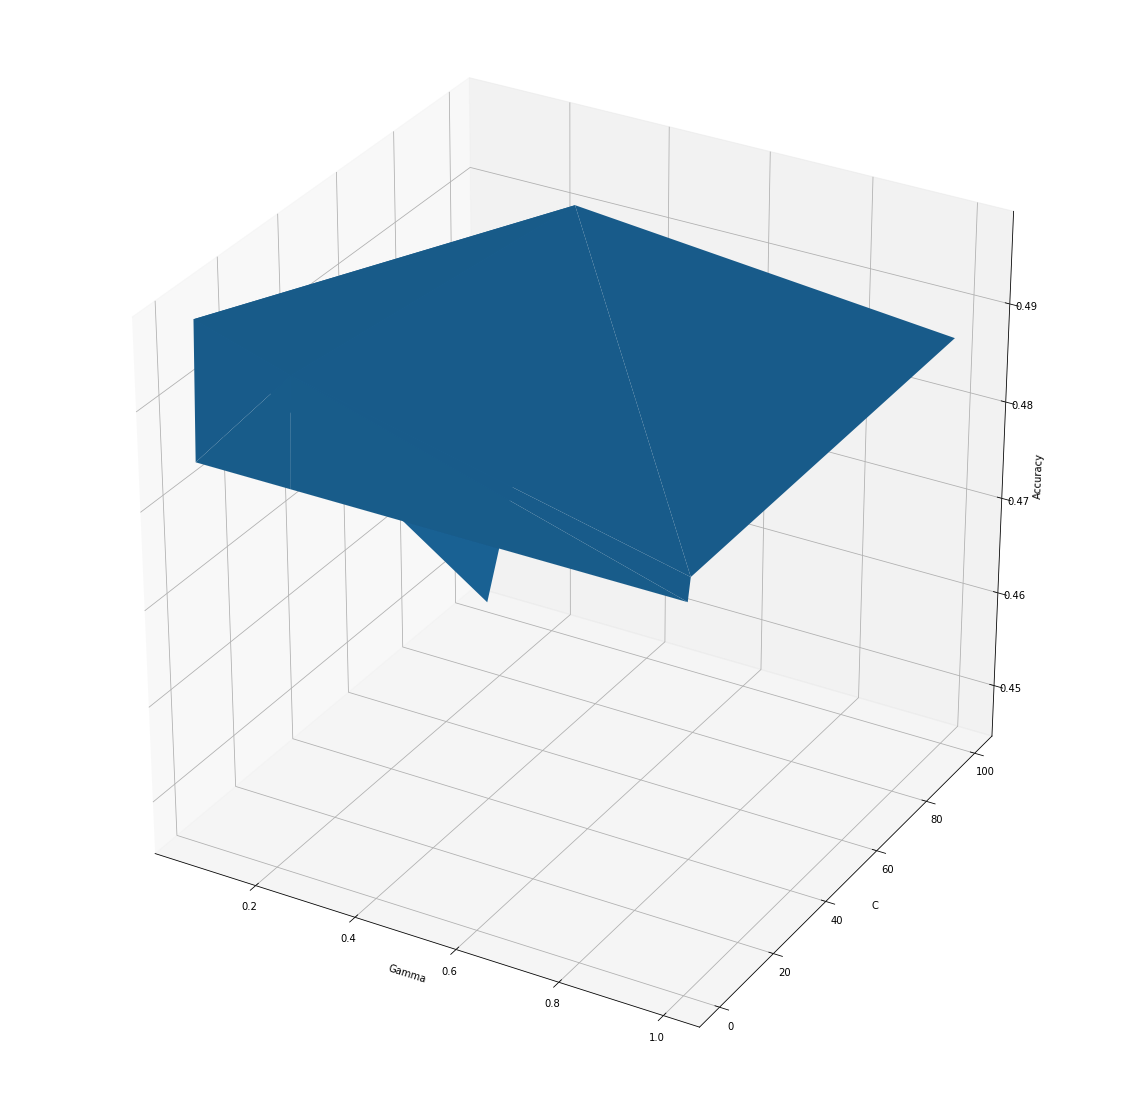

In [14]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
# Axes3D import has side effects, it enables using projection='3d' in add_subplot
import matplotlib.pyplot as plt
import random

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(df['gamma'], df['C'], df['accuracy'])

ax.set_xlabel('Gamma')
ax.set_ylabel('C')
ax.set_zlabel('Accuracy')

plt.show()

In [15]:
def getBestAcc(df_acc):
    bests = []
    max = 0
    for row in df_acc.itertuples(index=True, name='Pandas'):
        if getattr(row, "accuracy") > max:
            bests = []
            toApp = [getattr(row, "C"), getattr(row, "gamma"), getattr(row, "accuracy")]
            bests.append(toApp)
            max = getattr(row, "accuracy")
        elif getattr(row, "accuracy") == max:
            toApp = [getattr(row, "C"), getattr(row, "gamma"), getattr(row, "accuracy")]
            bests.append(toApp)
    return bests

In [16]:
getBestAcc(df)

[['1', '0.0625', 0.4981738495252009]]

###  So, After tuning, we have several optimum C and gamma values
```
C: 1,   Gamma: 0.0625, Accuracy: 1.0
C: 1,   Gamma: 0.125,  Accuracy: 1.0
C: 10,  Gamma: 0.0625, Accuracy: 1.0
C: 10,  Gamma: 0.125,  Accuracy: 1.0
C: 100, Gamma: 0.0625, Accuracy: 1.0
C: 100, Gamma: 0.125,  Accuracy: 1.0

So Let's pick one of them and test our data
Picked:
C: 10,  Gamma: 0.0625
```

In [17]:
gamma = 0.0625
C = 1
# Create a SVC classifier using an RBF kernel
svc = SVC(kernel='rbf', random_state=0, gamma=gamma, C=C)
svc.fit(X_train_orig, y_train_orig)
y_pred = svc.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
accuracies[f"{C}_{gamma}"] = accuracy
print(f"C: {C}\t Gamma: {gamma}\t Accuracy: {accuracy}")

C: 1	 Gamma: 0.0625	 Accuracy: 0.5178962746530315


## Resulting Accuracy: 1.0

In [18]:
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [148]:
np.savetxt("Decisions_RBF_Kernel.txt", y_pred, fmt='%d')

# SGD Optimization

In [33]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

numFolds = 10
kf = KFold(numFolds, shuffle=True)

# These are "Class objects". For each Class, find the AUC through
# 10 fold cross validation.
Model = SGDClassifier

# Added max_iter here
params = []
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
param = { 
               "loss": "log", 
               "penalty": "l2", 
               'max_iter':1000
        }
for alpha in alphas:
    paramTmp = param.copy()
    paramTmp['alpha'] = alpha
    params.extend([paramTmp])

print(params)

for param in params:
    total = 0
    for train_indices, test_indices in kf.split(X_train_orig):
        train_X = X_train_orig.values[train_indices, :]; train_Y = y_train_orig.values[train_indices]
        test_X = X_train_orig.values[test_indices, :]; test_Y = y_train_orig.values[test_indices]
        reg = Model(**param)
        reg.fit(train_X, train_Y)
        predictions = reg.predict(test_X)
        total += accuracy_score(test_Y, predictions)

    accuracy = total / numFolds
    print("Accuracy score of {0} with Alpha {2}: {1}".format(Model.__name__, accuracy, param['alpha']))


[{'loss': 'log', 'penalty': 'l2', 'max_iter': 1000, 'alpha': 0.0001}, {'loss': 'log', 'penalty': 'l2', 'max_iter': 1000, 'alpha': 0.001}, {'loss': 'log', 'penalty': 'l2', 'max_iter': 1000, 'alpha': 0.01}, {'loss': 'log', 'penalty': 'l2', 'max_iter': 1000, 'alpha': 0.1}, {'loss': 'log', 'penalty': 'l2', 'max_iter': 1000, 'alpha': 1.0}, {'loss': 'log', 'penalty': 'l2', 'max_iter': 1000, 'alpha': 10.0}, {'loss': 'log', 'penalty': 'l2', 'max_iter': 1000, 'alpha': 100.0}, {'loss': 'log', 'penalty': 'l2', 'max_iter': 1000, 'alpha': 1000.0}]
Accuracy score of SGDClassifier with Alpha 0.0001: 0.44629064972844584
Accuracy score of SGDClassifier with Alpha 0.001: 0.45853093849664395
Accuracy score of SGDClassifier with Alpha 0.01: 0.4824717436848637
Accuracy score of SGDClassifier with Alpha 0.1: 0.47898424051561933
Accuracy score of SGDClassifier with Alpha 1.0: 0.4789992527255501
Accuracy score of SGDClassifier with Alpha 10.0: 0.4532186178091515
Accuracy score of SGDClassifier with Alpha 100.

## Random Forests

In [38]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [39]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 60, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 1100, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(df_features, df_labels)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:   43.6s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  5.9min remaining:  4.8min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  6.9min remaining:  2.9min


In [ ]:
rf_random.best_params_